# Initialization

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
from importlib import reload
import utils; reload(utils)
from utils import *
from __future__ import division, print_function
path = "data/weather/"
model_path = path + 'models/'

Using TensorFlow backend.


## Model params

- `batch_size` is the training minibatch size: 64-128 seems to work fairly well
- `seq_length` is the number of time samples spread through the previous week to feed into the model for prediction.  32 might be overkill but gives a lot of data for the model to spot patterns on.
- `fp_fn_ratio` is the relative cost of a false negative over a false postive.  That is, if set to `10`, then *not* turning on the sprinklers when there is a frost is considered to be 10x as bad as turning on the sprinklers when there is no frost.

In [3]:
batch_size=128
seq_length=32
fp_fn_ratio=10

# Historic Data

## Actuals from Wunderground

We read in the raw historic data from the CSV file that we pulled from Wunderground using https://github.com/CienegaOrchards/weather-download

The timestamps in there are UTC, but we care about local time, so adjust for that.
Some rows are duplicated in the CSV for some reason; so trim those.  There's also some entries where the data is corrupted, so remove those too.

Then, what we want to try and predict is whether or not the temperature will drop below some threshold within the next 10 hours.  So we do a rolling window looking forward 10 hours and figure out what the minimum temperature will be in that time.  Pandas doesn't do rolling windows forward, so we do a rolling window backwards and then shift that by 10 hours.

Once we have the rolling look-forward minimums, we also figure out the day-of-year (which the model can use to infer seasonal weather patterns), and hour-of-day (so the model can figure out daily patterns).

We then construct a field called `threshold` which tracks whether the look-ahead temp crosses some threshold temp.  We can have a model that tries to forecast *which* threshold we cross by introducing multiple thresholds here, or just have a single threshold.  Then we one-hot that threshold field.

In [4]:
data = pd.read_csv(path + 'all_data.csv', index_col='DateUTC', parse_dates=['DateUTC'],
                   usecols=['DateUTC','TemperatureF','DewpointF','PressureIn',
                            'WindSpeedMPH','WindSpeedGustMPH','Humidity','HourlyPrecipIn',
                            'dailyrainin','SolarRadiationWatts/m^2'])
data.index = data.index.tz_localize('UTC').tz_convert('US/Pacific')
data.drop_duplicates(inplace=True)

data = data[data.TemperatureF > 0] # Remove bad temp
data = data[data.PressureIn   > 0] # Remove bad pressure
data = data[data.HourlyPrecipIn >= 0] # Remove bad rainfall

data = data.assign(forward_min = data.rolling('10h', closed='both').TemperatureF.min().shift(-1,'10h').asof(data.index))

data = data.assign(day_of_year = data.index.dayofyear, hour = data.index.hour)
data = data.assign(threshold = 'no')
data.loc[data.forward_min < 32,'threshold'] = '32'
# data.loc[data.forward_min < 30,'threshold'] = '30'
# data.loc[data.forward_min < 28,'threshold'] = '28'

data = data.merge(pd.get_dummies(data.threshold, prefix='threshold'), left_index=True, right_index=True)

data.head()

,TemperatureF,DewpointF,PressureIn,WindSpeedMPH,WindSpeedGustMPH,Humidity,HourlyPrecipIn,dailyrainin,SolarRadiationWatts/m^2,forward_min,day_of_year,hour,threshold,threshold_32,threshold_no
DateUTC,,,,,,,,,,,,,,,
2016-02-16 11:12:00-08:00,73.8,50.5,29.29,0.0,0.0,44,0.0,0.0,17.48,73.8,47,11,no,0,1
2016-02-16 11:14:00-08:00,74.5,50.5,29.29,0.0,0.0,43,0.0,0.0,17.48,73.8,47,11,no,0,1
2016-02-16 11:15:00-08:00,74.5,50.5,29.28,0.0,0.0,43,0.0,0.0,17.48,73.8,47,11,no,0,1
2016-02-16 11:16:00-08:00,74.5,50.5,29.27,0.0,0.0,43,0.0,0.0,17.53,73.8,47,11,no,0,1
2016-02-16 11:23:00-08:00,74.5,50.0,29.96,0.0,0.0,42,0.0,0.0,17.43,73.8,47,11,no,0,1


## Historic forecasts as recorded in Dynamo weather_log table

In [7]:
forecasts = pd.read_csv(path+'forecast-current-2017-08-08-14-25-45.csv', parse_dates=['time'], index_col='time', usecols=['time','forecast'], dtype={'forecast': 'float'})
forecasts = forecasts.tz_localize('UTC').tz_convert('US/Pacific')

data = data.assign(forecast = forecasts.asof(data.index)).dropna()
data.head()

,TemperatureF,DewpointF,PressureIn,WindSpeedMPH,WindSpeedGustMPH,Humidity,HourlyPrecipIn,dailyrainin,SolarRadiationWatts/m^2,forward_min,day_of_year,hour,threshold,threshold_32,threshold_no,forecast
DateUTC,,,,,,,,,,,,,,,,
2016-02-28 17:32:00-08:00,61.2,49.3,30.13,0.0,0.0,65,0.0,0.0,10.68,38.8,59,17,no,0,1,58.0
2016-02-28 17:37:00-08:00,60.8,48.9,30.14,0.0,0.0,65,0.0,0.0,8.39,38.8,59,17,no,0,1,58.0
2016-02-28 17:42:00-08:00,60.6,49.6,30.13,0.0,0.0,67,0.0,0.0,6.21,38.8,59,17,no,0,1,58.0
2016-02-28 17:47:00-08:00,60.3,49.6,30.13,0.0,0.0,68,0.0,0.0,1.43,38.8,59,17,no,0,1,58.0
2016-02-28 17:57:00-08:00,59.7,51.1,30.13,0.0,0.0,73,0.0,0.0,0.00,38.8,59,17,no,0,1,58.0


## Sequence of dates back in time with exponential steps

The idea here is that we want to make predictions based on the most-recent week's worth of weather data; so we'll take the historic actuals, and snapshot at intervals going back in time, starting with current data; then 30 minutes ago; then `30*m` where `m` is some multiple, up to `30*(m^x)` where x is enough iterations to reach a total of 1 week (60*24*7 minutes) of data.  The sequence length is how many data points there'll be feeding into the prediction engine, and the math will space those out in an exponential curve so that we have more data points which are more recent in time, and fewer as we reach back towards a week ago.

In [8]:
minutes_in_week = 60*24*7+30
base = 30
multiple = np.exp(np.log(minutes_in_week/base)/(seq_length-1))
from pandas.tseries.offsets import *
offsets = pd.Series(DateOffset(minutes = base*(multiple**i-1)) for i in range(seq_length-1,-1,-1))
offsets

0     <DateOffset: kwds={'minutes': 10079.99999999998}>
1     <DateOffset: kwds={'minutes': 8349.434435135774}>
2     <DateOffset: kwds={'minutes': 6915.09608830260...
3     <DateOffset: kwds={'minutes': 5726.27866643419...
4     <DateOffset: kwds={'minutes': 4740.95545754265...
5     <DateOffset: kwds={'minutes': 3924.29361517625...
6     <DateOffset: kwds={'minutes': 3247.42275822408...
7     <DateOffset: kwds={'minutes': 2686.41435398226...
8     <DateOffset: kwds={'minutes': 2221.43580394224...
9     <DateOffset: kwds={'minutes': 1836.04932779933...
10    <DateOffset: kwds={'minutes': 1516.630860041915}>
11    <DateOffset: kwds={'minutes': 1251.88841613045...
12    <DateOffset: kwds={'minutes': 1032.46290169388...
13    <DateOffset: kwds={'minutes': 850.5972526714213}>
14    <DateOffset: kwds={'minutes': 699.862209942718...
15     <DateOffset: kwds={'minutes': 574.929034114572}>
16    <DateOffset: kwds={'minutes': 471.381125546298...
17    <DateOffset: kwds={'minutes': 385.55789006

## Build the data sequences

Now we actually build the data sequences.  It takes a LONG time to run this; welcome to Python... I haven't been able to come up with a good way to get Pandas to do this more efficiently than having the loop in Python and calling multiply into Pandas native code.  There's possibly some clever way of using Pandas to handle the iteration though by using multiple resamples or shifts or something.  For now, we just run the calculation once then save the resulting data frame so that we can just re-load it and not have to repeat the iteration.  The iteration will need to be re-done though any time the sequence length is changed, or if the time slicing exponential thingie is changed above.  The `all_y` is very fast though, so we can adjust what we're trying to predict with no big penalty -- that doesn't need to be saved/loaded.

In [9]:
wanted_cols = data[['TemperatureF','DewpointF','PressureIn','WindSpeedMPH','WindSpeedGustMPH',
                    'Humidity','HourlyPrecipIn','dailyrainin','SolarRadiationWatts/m^2',
                    'day_of_year','hour','forecast']]

# TODO: This below takes about 12 minutes to run on 105,241 data points with seq_length=10.  Surely that could be faster??!?
#       This below takes about 41 minutes to run on 104,733 data points with seq_length=32.  Surely that could be faster??!?

# all_x = np.nan_to_num([wanted_cols.loc[([wanted_cols.index.asof(i) for i in (idx-offsets)])].values for idx in zip(wanted_cols.index)])
# save_array(path+'all_x', all_x)

all_x = load_array(path+'all_x')
all_y = data.threshold_32.values.reshape(-1,1)

all_x.shape, all_y.shape

((104733, 32, 12), (104733, 1))

### Rescale all the things

In [10]:
inputs_scaler = StandardScaler()
num_params = all_x.shape[2]

all_x = inputs_scaler.fit_transform(all_x.reshape(-1,num_params)).reshape(-1,seq_length,num_params)

## Split into Train/Validation

We want to split the data fairly into train/validation data.  There might be patterns in the day-of-the-week based on activity on the ranch, so I don't want to split on day-of-week and use one weekday for validation.  Using `day-of-year%10` seems to be reasonably fair, then we get some of each weekday in both sets.

In [11]:
train_idx = np.where(data.day_of_year%10!=3)
val_idx = np.where(data.day_of_year%10==3)

train_x, train_y = all_x[train_idx], all_y[train_idx]
val_x, val_y = all_x[val_idx], all_y[val_idx]

train_data = data.iloc[train_idx]
validation_data = data.iloc[val_idx]

train_x.shape, train_y.shape, val_x.shape, val_y.shape, train_y.sum(), val_y.sum()

((94186, 32, 12), (94186, 1), (10547, 32, 12), (10547, 1), 4263, 439)

# The Model

I'm going to use a CNN here, where I'm creating convolutions over the time dimension (across the sequence of time-based data points).  This will allow the model to pick up patterns in how the data change over the course of a week, and how those changes can predict our output variable(s).  We use causal padding for replacement in the convolution layers.  I batch-normalize the input data, and then use dropout while training to reduce over-fit.  A small FC hidden layer combines down the features identified by the convolution layers.  When predicting a single threshold, I use binary_crossentropy as my loss function; for multi-threshold I would switch to categorical_crossentropy or more likely top-2 accuracy or something.

In [63]:
model = Sequential([
    GaussianNoise(0.5, input_shape=(seq_length, train_x.shape[2])),
    
    Conv1D(32, 3, padding='causal'),
    keras.layers.advanced_activations.PReLU(),
    BatchNormalization(),
    Conv1D(32, 3, padding='causal'),
    keras.layers.advanced_activations.PReLU(),
    MaxPooling1D(),
    BatchNormalization(),

    Conv1D(64, 3, padding='causal'),
    keras.layers.advanced_activations.PReLU(),
    BatchNormalization(),
    Conv1D(64, 3, padding='causal'),
    keras.layers.advanced_activations.PReLU(),
    MaxPooling1D(),
    BatchNormalization(),

#     Conv1D(256, 3, padding='causal'),
#     keras.layers.advanced_activations.PReLU(),
#     BatchNormalization(),
#     Conv1D(256, 3, padding='causal'),
#     keras.layers.advanced_activations.PReLU(),
#     MaxPooling1D(),
#     BatchNormalization(),

#     Conv1D(4, 3, padding='same', activation='relu'),
#     MaxPooling1D(),
#     BatchNormalization(),

#     Conv1D(512, 3, padding='same', activation='relu'),
#     BatchNormalization(),
#     Conv1D(512, 3, padding='same', activation='relu'),
#     BatchNormalization(),
#     MaxPooling1D(4),
    
    Flatten(),
    
    Dense(1024),
    keras.layers.advanced_activations.PReLU(),
    BatchNormalization(),
    
    Dropout(0.75),
    Dense(train_y.shape[1], activation='sigmoid'),
])
model.compile(Nadam(), 'binary_crossentropy', ['binary_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_16 (GaussianN (None, 32, 12)            0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 32, 32)            1184      
_________________________________________________________________
p_re_lu_86 (PReLU)           (None, 32, 32)            1024      
_________________________________________________________________
batch_normalization_86 (Batc (None, 32, 32)            128       
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 32, 32)            3104      
_________________________________________________________________
p_re_lu_87 (PReLU)           (None, 32, 32)            1024      
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 16, 32)            0         
__________

# Training run

The callback function here will plot a short graph every few epochs to give an indication of how many, and how severe are the false positives & false negatives predicted by the model against the validation data.  Peaks are times where the forward temperature *did* drop below the threshold but the model did not predict so; valleys are where the model predicts a threshold break but the weather did not actually get that cold.

I also have a callback to automatically lower the learning rate when progress stalls.

Train on 94186 samples, validate on 10547 samples
Epoch 1/20
93824/94186 [============================>.] - ETA: 0s - loss: 0.2828 - binary_accuracy: 0.9353

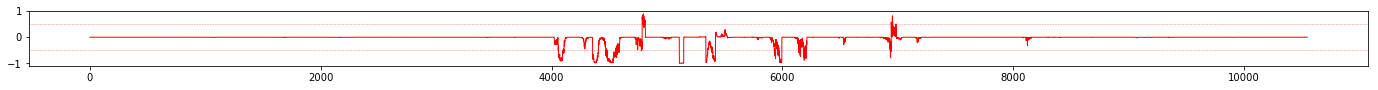

94186/94186 [==============================] - 22s - loss: 0.2826 - binary_accuracy: 0.9353 - val_loss: 0.0902 - val_binary_accuracy: 0.9638
Epoch 2/20
93824/94186 [============================>.] - ETA: 0s - loss: 0.1220 - binary_accuracy: 0.9733

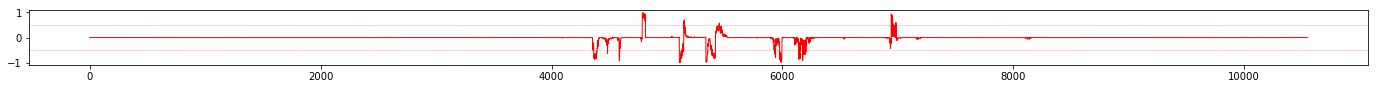

94186/94186 [==============================] - 15s - loss: 0.1221 - binary_accuracy: 0.9733 - val_loss: 0.0430 - val_binary_accuracy: 0.9803
Epoch 3/20
93824/94186 [============================>.] - ETA: 0s - loss: 0.0890 - binary_accuracy: 0.9803

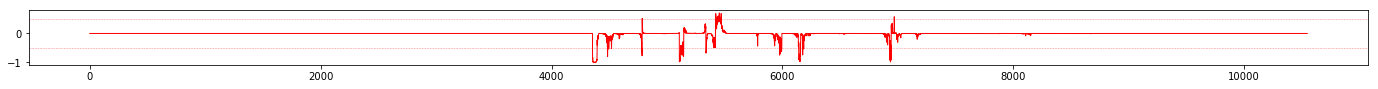

94186/94186 [==============================] - 15s - loss: 0.0889 - binary_accuracy: 0.9803 - val_loss: 0.0410 - val_binary_accuracy: 0.9861
Epoch 4/20
93824/94186 [============================>.] - ETA: 0s - loss: 0.0827 - binary_accuracy: 0.9820

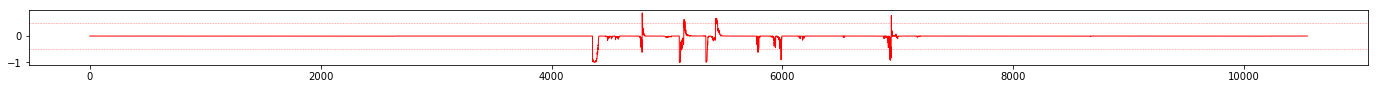

94186/94186 [==============================] - 15s - loss: 0.0827 - binary_accuracy: 0.9820 - val_loss: 0.0330 - val_binary_accuracy: 0.9898
Epoch 5/20
93824/94186 [============================>.] - ETA: 0s - loss: 0.0734 - binary_accuracy: 0.9847

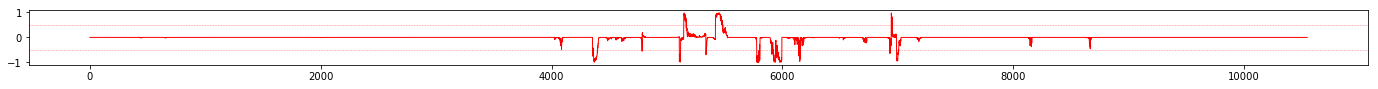

94186/94186 [==============================] - 16s - loss: 0.0733 - binary_accuracy: 0.9847 - val_loss: 0.0629 - val_binary_accuracy: 0.9743
Epoch 6/20
93824/94186 [============================>.] - ETA: 0s - loss: 0.0589 - binary_accuracy: 0.9874

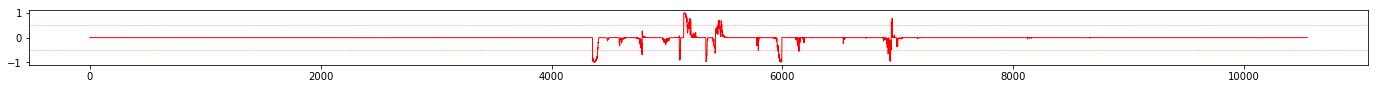

94186/94186 [==============================] - 16s - loss: 0.0589 - binary_accuracy: 0.9874 - val_loss: 0.0440 - val_binary_accuracy: 0.9839
Epoch 7/20
93824/94186 [============================>.] - ETA: 0s - loss: 0.0593 - binary_accuracy: 0.9882

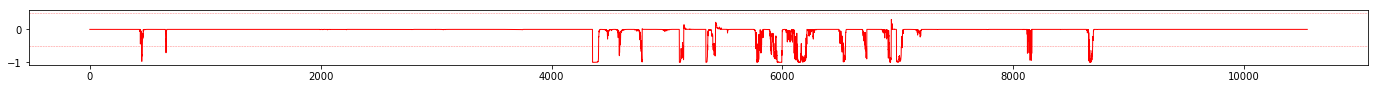

94186/94186 [==============================] - 15s - loss: 0.0601 - binary_accuracy: 0.9882 - val_loss: 0.1648 - val_binary_accuracy: 0.9542
Epoch 8/20
93824/94186 [============================>.] - ETA: 0s - loss: 0.0528 - binary_accuracy: 0.9892
Epoch 00007: reducing learning rate to 0.0006000000284984708.


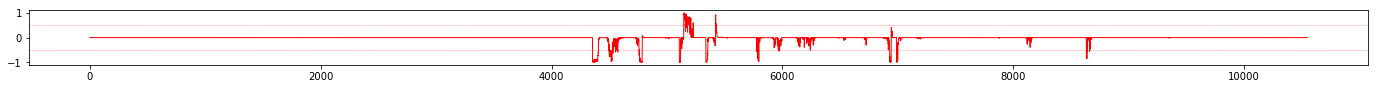

94186/94186 [==============================] - 17s - loss: 0.0530 - binary_accuracy: 0.9892 - val_loss: 0.0671 - val_binary_accuracy: 0.9780
Epoch 9/20
93824/94186 [============================>.] - ETA: 0s - loss: 0.0322 - binary_accuracy: 0.9929

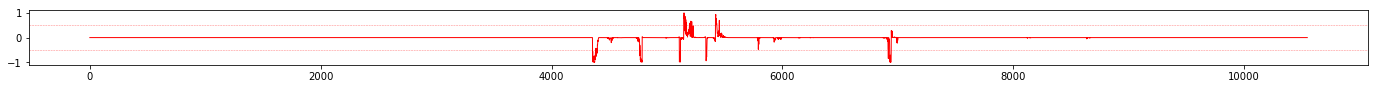

94186/94186 [==============================] - 16s - loss: 0.0321 - binary_accuracy: 0.9929 - val_loss: 0.0314 - val_binary_accuracy: 0.9881
Epoch 10/20
94080/94186 [============================>.] - ETA: 0s - loss: 0.0292 - binary_accuracy: 0.9938

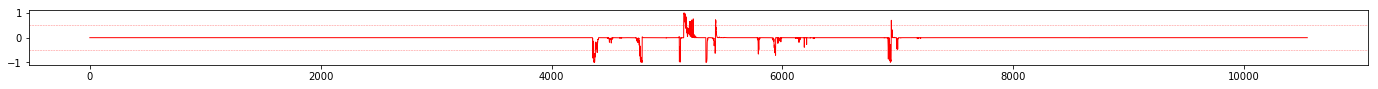

94186/94186 [==============================] - 16s - loss: 0.0292 - binary_accuracy: 0.9938 - val_loss: 0.0309 - val_binary_accuracy: 0.9896
Epoch 11/20
93824/94186 [============================>.] - ETA: 0s - loss: 0.0261 - binary_accuracy: 0.9944

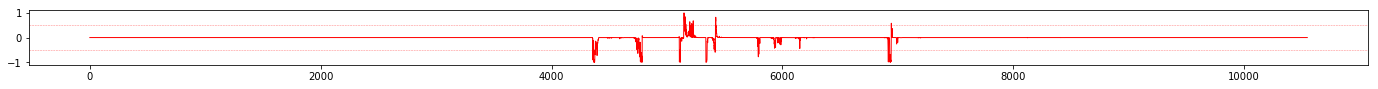

94186/94186 [==============================] - 15s - loss: 0.0262 - binary_accuracy: 0.9944 - val_loss: 0.0303 - val_binary_accuracy: 0.9903
Epoch 12/20
93824/94186 [============================>.] - ETA: 0s - loss: 0.0264 - binary_accuracy: 0.9942

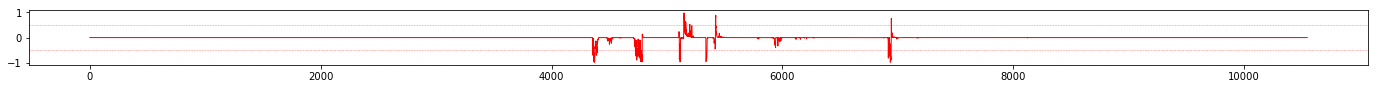

94186/94186 [==============================] - 16s - loss: 0.0264 - binary_accuracy: 0.9942 - val_loss: 0.0208 - val_binary_accuracy: 0.9907
Epoch 13/20
93824/94186 [============================>.] - ETA: 0s - loss: 0.0268 - binary_accuracy: 0.9941

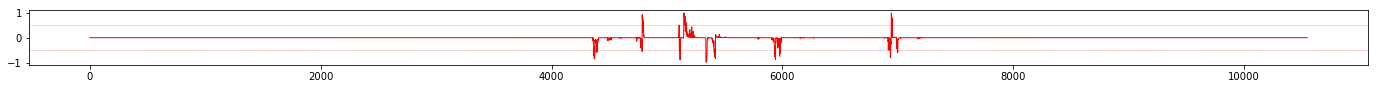

94186/94186 [==============================] - 15s - loss: 0.0267 - binary_accuracy: 0.9942 - val_loss: 0.0176 - val_binary_accuracy: 0.9922
Epoch 14/20
93824/94186 [============================>.] - ETA: 0s - loss: 0.0235 - binary_accuracy: 0.9950

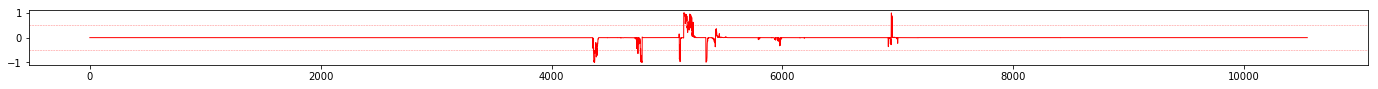

94186/94186 [==============================] - 16s - loss: 0.0234 - binary_accuracy: 0.9950 - val_loss: 0.0282 - val_binary_accuracy: 0.9891
Epoch 15/20
93824/94186 [============================>.] - ETA: 0s - loss: 0.0236 - binary_accuracy: 0.9950

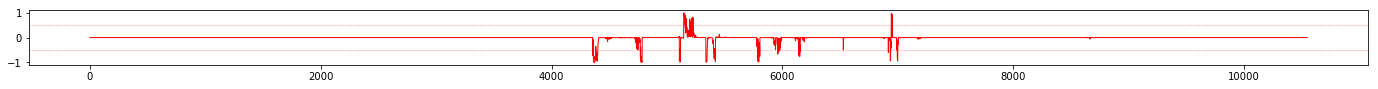

94186/94186 [==============================] - 16s - loss: 0.0236 - binary_accuracy: 0.9951 - val_loss: 0.0397 - val_binary_accuracy: 0.9854
Epoch 16/20
93824/94186 [============================>.] - ETA: 0s - loss: 0.0257 - binary_accuracy: 0.9947

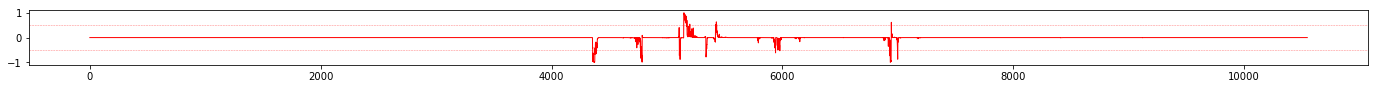

94186/94186 [==============================] - 15s - loss: 0.0257 - binary_accuracy: 0.9947 - val_loss: 0.0249 - val_binary_accuracy: 0.9917
Epoch 17/20
93824/94186 [============================>.] - ETA: 0s - loss: 0.0232 - binary_accuracy: 0.9950
Epoch 00016: reducing learning rate to 0.00018000000854954124.


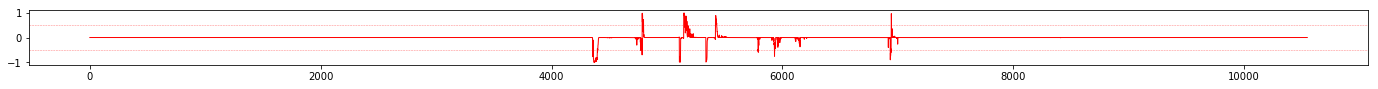

94186/94186 [==============================] - 15s - loss: 0.0233 - binary_accuracy: 0.9950 - val_loss: 0.0282 - val_binary_accuracy: 0.9897
Epoch 18/20
93824/94186 [============================>.] - ETA: 0s - loss: 0.0196 - binary_accuracy: 0.9958

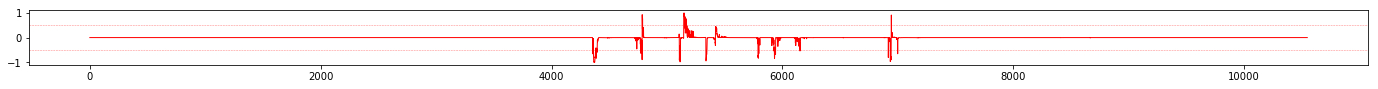

94186/94186 [==============================] - 16s - loss: 0.0197 - binary_accuracy: 0.9958 - val_loss: 0.0224 - val_binary_accuracy: 0.9910
Epoch 19/20
93824/94186 [============================>.] - ETA: 0s - loss: 0.0208 - binary_accuracy: 0.9954

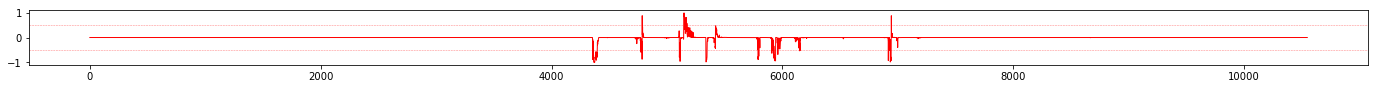

94186/94186 [==============================] - 16s - loss: 0.0209 - binary_accuracy: 0.9954 - val_loss: 0.0278 - val_binary_accuracy: 0.9895
Epoch 20/20
94080/94186 [============================>.] - ETA: 0s - loss: 0.0179 - binary_accuracy: 0.9958
Epoch 00019: reducing learning rate to 5.400000081863254e-05.


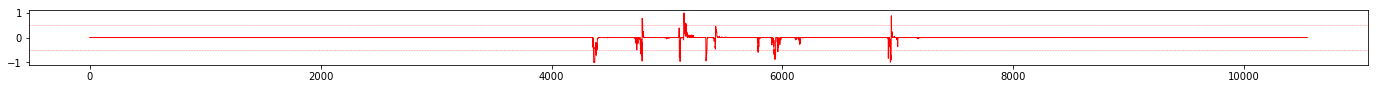

94186/94186 [==============================] - 15s - loss: 0.0180 - binary_accuracy: 0.9958 - val_loss: 0.0183 - val_binary_accuracy: 0.9931


In [64]:
class GraphCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
#         if epoch%2==1:
            plt.figure(figsize=(24,1))
            plt.plot((val_y-(model.predict(val_x, batch_size=batch_size))), 'r', lw=1)
            plt.axhline(0.5, color='r', ls='dashed', lw=0.5, alpha=0.5)
            plt.axhline(-0.5, color='r', ls='dashed', lw=0.5, alpha=0.5)
            plt.show()

reduce_lr = ReduceLROnPlateau(factor=0.3, patience=3, verbose=1)
graph_cb = GraphCallback()

history = model.fit(train_x, train_y,
          epochs=20,
          batch_size=batch_size,
          validation_data=(val_x, val_y),
          class_weight={0:1, 1:fp_fn_ratio, 2:fp_fn_ratio**2},
          callbacks=[reduce_lr, graph_cb])

# Evaluate model

dict_keys(['lr', 'val_loss', 'loss', 'binary_accuracy', 'val_binary_accuracy'])


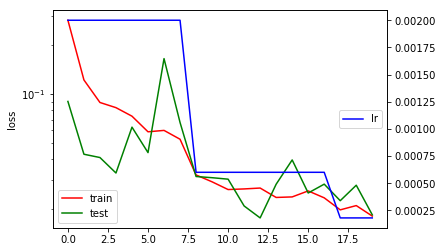

In [65]:
print(history.history.keys())
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_yscale('log')
ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='g')
ax1.set_ylabel('loss')
ax1.legend(['train', 'test'], loc='lower left')
ax2.plot(history.history['lr'], color='b')
ax2.legend(['lr'], loc='center right')
plt.xlabel('epoch')
plt.show()

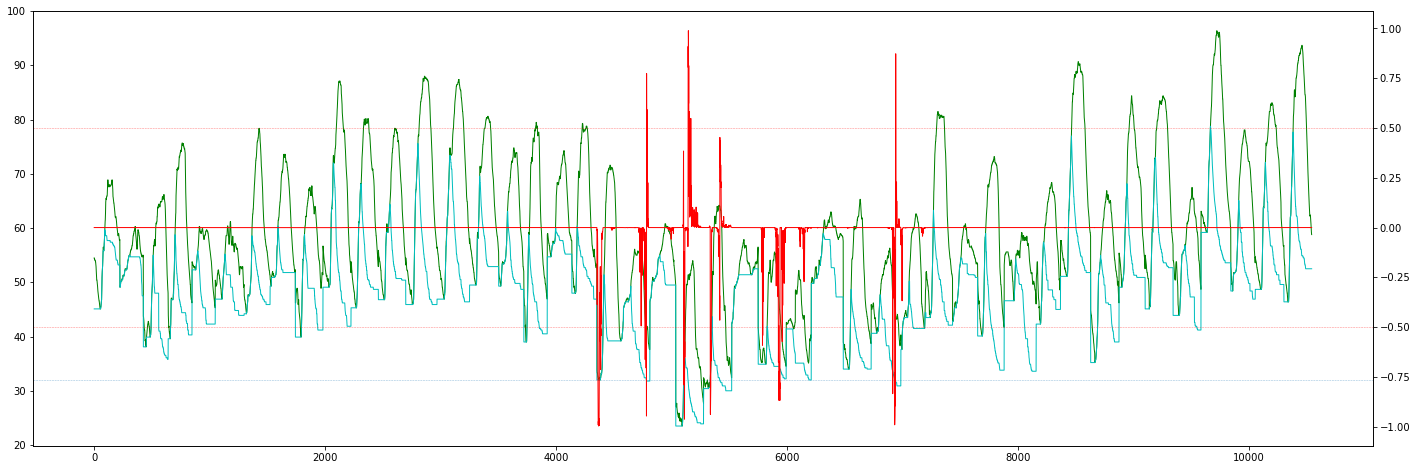

In [66]:
fig, ax1 = plt.subplots(figsize=(24,8))
ax2 = ax1.twinx()
ax1.plot(validation_data.TemperatureF.as_matrix(), 'g', lw=1)
ax1.plot(validation_data.forward_min.as_matrix(), 'c', lw=1)
ax2.plot(val_y-model.predict(val_x, batch_size=batch_size), 'r', lw=1)
ax2.axhline(0.5, color='r', ls='dashed', lw=0.5, alpha=0.5)
ax2.axhline(-0.5, color='r', ls='dashed', lw=0.5, alpha=0.5)

ax1.axhline(32, ls='dashed', lw=0.5, alpha=0.5)
plt.show()

In [67]:
prediction_data = validation_data.assign(prediction = np.round(model.predict(val_x, batch_size=batch_size)).astype(int))
prediction_data.index = prediction_data.index.tz_convert('UTC')
prediction_data = prediction_data.merge(pd.get_dummies(prediction_data.prediction, prefix='prediction'), left_index=True, right_index=True)
prediction_data = prediction_data.assign(fn = prediction_data.threshold_32*prediction_data.prediction_0)
prediction_data = prediction_data.assign(fp = prediction_data.threshold_no*prediction_data.prediction_1)

In [68]:
resample = '2H'
extract = prediction_data.TemperatureF.resample(resample).min().to_frame().merge(prediction_data.forward_min.resample(resample).min().to_frame(), left_index=True, right_index=True).merge(prediction_data.threshold_32.resample(resample).max().to_frame(), left_index=True, right_index=True).merge(prediction_data.prediction_1.resample(resample).max().to_frame(), left_index=True, right_index=True).merge(prediction_data.fn.resample(resample).prod().to_frame(), left_index=True, right_index=True).merge(prediction_data.fp.resample(resample).prod().to_frame(), left_index=True, right_index=True)
extract.fp = extract.fp * 32
extract.fn = extract.fn * 32
extract.fp[extract.fp==0] = float('nan')
extract.fn[extract.fn==0] = float('nan')
extract.fn.count(), extract.fp.count()

(0, 1)

In [70]:
model.save_weights(model_path+'model.h5')

OSError: Unable to create file (Unable to truncate a file which is already open)